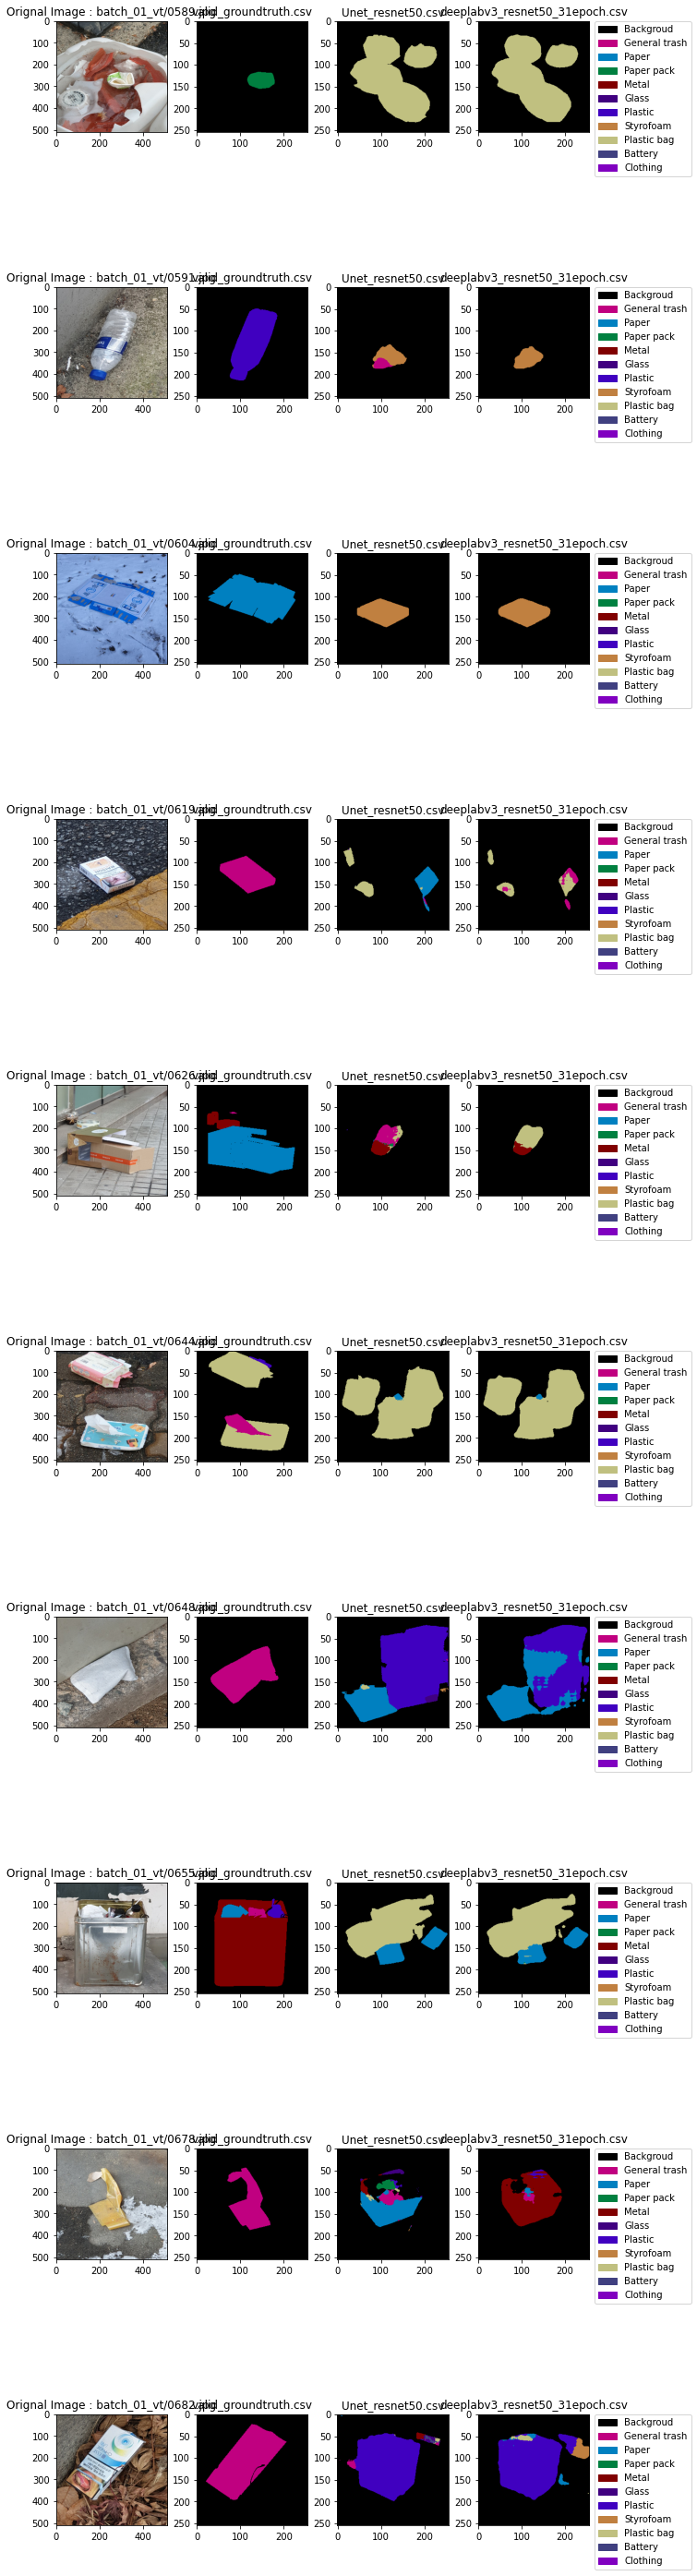

In [2]:
import os
import cv2
import csv
import pandas as pd
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
import numpy as np
import webcolors

#compare inference result (csv file) by visualization
csv_root = '../seg-model-lib/submission/'
csv_names = ['Unet_resnet50.csv', 'deeplabv3_resnet50_31epoch.csv']

submission_paths = [csv_root + csv_name for csv_name in csv_names]

root='../input/data/'

class_colormap = [[0,0,0],
               [192,0,128],
               [0,128,192],
               [0,128,64],
               [128,0,0],
               [64,0,128],
               [64,0,192],
               [192,128,64],
               [192,192,128],
               [64,64,128],
               [128,0,192]]
CLASSES = ("Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (r, g, b) in enumerate(class_colormap):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

def visualization(num_examples, index):
    category_and_rgb = [[CLASSES[idx], (r,g,b)] for idx, (r, g, b) in enumerate(class_colormap)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]
    
    images = []
    masks_list = []

    submission = pd.read_csv(submission_paths[0], index_col=None)[index:index + num_examples]
    image_ids = submission["image_id"].values
    masks_list.append(submission["PredictionString"].values)

    for submission_path in submission_paths[1:]:
        submission = pd.read_csv(submission_path, index_col=None)[index:index + num_examples]
        masks_list.append(submission["PredictionString"].values)

    # image load
    for i in range(num_examples):
        image_id = image_ids[i]
        image = cv2.imread(os.path.join(root, image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        images.append(image)
    
    for masks in masks_list:
        for m in range(num_examples):
            mask = list(map(int, masks[m].split()))
            mask = np.array(mask)
            mask = np.reshape(mask, (256, 256))
            masks[m] = mask
        
    # plt 생성
    fig, ax = plt.subplots(nrows=num_examples, ncols=len(masks_list)+1, figsize=(10, 4*num_examples), constrained_layout=True)
    
    for row_num in range(num_examples):
        
        # Original Image
        ax[row_num][0].imshow(images[row_num])
        ax[row_num][0].set_title(f"Orignal Image : {image_ids[row_num]}")
        
        # Pred Mask
        for masks_index in range(len(masks_list)):
            ax[row_num][masks_index + 1].imshow(label_to_color_image(masks_list[masks_index][row_num]))
            ax[row_num][masks_index + 1].set_title(f"{csv_names[masks_index]}")

        ax[row_num][len(masks_list)].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

    plt.show()

visualization(10, 102)